### NBA Fantasy

Opravili bomo analizo NBA sezone 2016/2017 z vidika NBA Fantasy točkovanja ter primerjali "natančnost" najpopularnejše metode točkovanja igralcev glede na dejanski uspeh ekip v rednem delu sezone.


Najprej naložimo vse .csv datoteke s podatki in si oglejmo, kateri podatki so nam na voljo za vsakega igralca:

In [1]:
import pandas as pd
import matplotlib as mplot

%matplotlib inline
pd.options.display.max_rows = 20
pd.set_option('precision', 2)
statistike = pd.read_csv('stats.csv', index_col = 'Index')
ekipe = pd.read_csv('team_stats.csv')
dvojni_dvojcki = pd.read_csv('dd.csv')
boljse_statistike = pd.merge(statistike, dvojni_dvojcki, how = 'outer')
boljse_statistike


/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/srv/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,Name,Position,Age,Team,GP,GS,MIN,FG,FGA,FG_PCT,...,DREB,TOTREB,AST,STL,BLK,TO,PF,PTS,DD,TD
0,Alex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.39,...,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,0,0
1,Quincy Acy,PF,26,TOT,38,1,14.7,1.8,4.5,0.41,...,2.5,3.0,0.5,0.4,0.4,0.6,1.8,5.8,0,0
2,Steven Adams,C,23,OKC,80,80,29.9,4.7,8.2,0.57,...,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3,16,0
3,Arron Afflalo,SG,31,SAC,61,45,25.9,3.0,6.9,0.44,...,1.9,2.0,1.3,0.3,0.1,0.7,1.7,8.4,0,0
4,Alexis Ajinca,C,28,NOP,39,15,15.0,2.3,4.6,0.50,...,3.4,4.5,0.3,0.5,0.6,0.8,2.0,5.3,1,0
5,Cole Aldrich,C,28,MIN,62,0,8.6,0.7,1.4,0.52,...,1.7,2.5,0.4,0.4,0.4,0.3,1.4,1.7,1,0
6,LaMarcus Aldridge,PF,31,SAS,72,72,32.4,6.9,14.6,0.48,...,4.9,7.3,1.9,0.6,1.2,1.4,2.2,17.3,18,0
7,Lavoy Allen,PF,27,IND,61,5,14.3,1.3,2.8,0.46,...,1.9,3.6,0.9,0.3,0.4,0.5,1.3,2.9,2,0
8,Tony Allen,SG,35,MEM,71,66,27.0,3.9,8.4,0.46,...,3.2,5.5,1.4,1.6,0.4,1.4,2.5,9.1,5,0
9,Al-Farouq Aminu,SF,26,POR,61,25,29.1,3.0,7.6,0.39,...,6.1,7.4,1.6,1.0,0.7,1.5,1.7,8.7,4,0


Tabelo igralcev sedaj združimo s statistiko zmag in porazov vsake ekipe:

In [2]:
igralci = pd.merge(boljse_statistike, ekipe, left_on = 'Team', right_on = 'Team', how = 'left')
igralci

,Name,Position,Age,Team,GP,GS,MIN,FG,FGA,FG_PCT,...,AST,STL,BLK,TO,PF,PTS,DD,TD,Wins,Losses
0,Alex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.39,...,0.6,0.5,0.1,0.5,1.7,6.0,0,0,47.0,35.0
1,Quincy Acy,PF,26,TOT,38,1,14.7,1.8,4.5,0.41,...,0.5,0.4,0.4,0.6,1.8,5.8,0,0,NaN,NaN
2,Steven Adams,C,23,OKC,80,80,29.9,4.7,8.2,0.57,...,1.1,1.1,1.0,1.8,2.4,11.3,16,0,47.0,35.0
3,Arron Afflalo,SG,31,SAC,61,45,25.9,3.0,6.9,0.44,...,1.3,0.3,0.1,0.7,1.7,8.4,0,0,32.0,50.0
4,Alexis Ajinca,C,28,NOP,39,15,15.0,2.3,4.6,0.50,...,0.3,0.5,0.6,0.8,2.0,5.3,1,0,34.0,48.0
5,Cole Aldrich,C,28,MIN,62,0,8.6,0.7,1.4,0.52,...,0.4,0.4,0.4,0.3,1.4,1.7,1,0,31.0,51.0
6,LaMarcus Aldridge,PF,31,SAS,72,72,32.4,6.9,14.6,0.48,...,1.9,0.6,1.2,1.4,2.2,17.3,18,0,61.0,21.0
7,Lavoy Allen,PF,27,IND,61,5,14.3,1.3,2.8,0.46,...,0.9,0.3,0.4,0.5,1.3,2.9,2,0,42.0,40.0
8,Tony Allen,SG,35,MEM,71,66,27.0,3.9,8.4,0.46,...,1.4,1.6,0.4,1.4,2.5,9.1,5,0,43.0,39.0
9,Al-Farouq Aminu,SF,26,POR,61,25,29.1,3.0,7.6,0.39,...,1.6,1.0,0.7,1.5,1.7,8.7,4,0,41.0,41.0


Takoj lahko opazimo, da imajo nekateri igralci prazno statistiko zmag in porazov. Po natančnejšem pregledu podatkov lahko ugotovimo, kaj imajo vsi ti igralci skupnega: igrajo v ekipi "TOT".

In [3]:
igralci[igralci.Team == 'TOT']

,Name,Position,Age,Team,GP,GS,MIN,FG,FGA,FG_PCT,...,AST,STL,BLK,TO,PF,PTS,DD,TD,Wins,Losses
1,Quincy Acy,PF,26,TOT,38,1,14.7,1.8,4.5,0.41,...,0.5,0.4,0.4,0.6,1.8,5.8,0,0,NaN,NaN
12,Justin Anderson,SF,23,TOT,75,10,16.4,2.5,5.9,0.42,...,0.9,0.5,0.3,0.9,1.5,7.1,0,0,NaN,NaN
28,Matt Barnes,SF,36,TOT,74,18,24.0,2.5,6.4,0.39,...,2.6,0.6,0.4,1.4,2.5,7.1,4,0,NaN,NaN
49,Bojan Bogdanovic,SF,27,TOT,81,54,25.7,4.6,10.4,0.45,...,1.4,0.4,0.1,1.6,1.8,13.7,0,0,NaN,NaN
50,Andrew Bogut,C,32,TOT,27,21,21.6,1.4,3.0,0.47,...,1.8,0.5,0.9,1.6,3.2,2.9,0,0,NaN,NaN
55,Corey Brewer,SF,30,TOT,82,11,15.6,1.8,4.2,0.42,...,1.2,0.7,0.2,0.7,1.6,4.5,0,0,NaN,NaN
58,Anthony Brown,SF,24,TOT,11,0,14.5,1.6,4.5,0.36,...,0.7,0.5,0.1,0.5,1.4,3.9,0,0,NaN,NaN
67,Jose Calderon,PG,35,TOT,41,13,13.1,1.3,3.3,0.41,...,2.1,0.3,0.0,1.0,0.9,3.4,0,0,NaN,NaN
74,Omri Casspi,SF,28,TOT,36,2,17.9,2.1,4.6,0.47,...,1.0,0.6,0.1,0.8,1.4,5.2,0,0,NaN,NaN
88,Quinn Cook,PG,23,TOT,14,0,13.4,2.4,4.7,0.50,...,1.9,0.3,0.0,0.9,0.9,5.6,0,0,NaN,NaN


"TOT" seveda ni ekipa, predstavlja skupno statistiko celotne sezone igralcev, ki so bili med letom zamenjani v drugo ekipo. Takih igralcev je skupno 53, kar ni ravno zanemarljivo (glede na skupno št. igralcev: 485), a jih v analizi uspeha ekip ne bomo mogli upoštevati, saj nimamo podatka o tem, v katerih ekipah so igrali ter koliko tekem v vsaki. Pri analizah individualnih statistik pa jih bomo seveda upoštevali.

Kot lahko razberemo iz zgornje razpredelnice, je statističnih kategorij, ki so v košarki relevantne, precej. Pri analizi dejanskega učinka igralcev na igrišču se zato ponavadi uporablja indeks PER, ki pa sam po sebi ni dovolj natančen, saj ga je treba vedno interpretirati v povezavi z odigranim časom posameznega igralca, sama formula pa je preveč zapletena in zato neprivlačna za manj strokovno podkovane košarkarske navdušence. Pri NBA Fantasy igrah na različnih spletnih straneh, pri katerih se med seboj pomerja milijone uporabnikov, je zato najpopularnejši način vrednotenja igralcev po vsaki tekmi spodnja formula, ki upošteva mosnovne statistične kategorije in jih različno obteži glede na dejansko "korist" posamezne statistike na igrišču, tako je na primer dosežena točka enako vredna kot zgrešen met, blokada pa pol točke več kot obrambni skok. Dodatne bonuse predstavljajo t. i. "dvojni" oz. "trojni dvojčki" ("Double double" in "Triple double" v angleščini - kadar igralec v različnih "pozitivnih" statistikah doseže dvomestno številko) ter zmaga ali poraz ekipe na posamezni tekmi.

Definirajmo torej formulo in izračunajmo povprečno ter skupno vrednost za vsakega igralca:

In [4]:
def fantasy_total(row):
    bonus = 5 * (row.DD + row.TD) + row.GS
    if not pd.isnull(row.Wins):
        team_bonus = 3 * (row.Wins - row.Losses) * row.GP / 82
    else:
        team_bonus = 0
    return row.GP * (row.PTS + row.DREB + (row.FG - row.FGA) + (row.FT - row.FTA) + 1.25 * row.OREB + 1.5 * (row.AST + row.STL + row.BLK - row.TO)) + bonus + team_bonus

In [5]:
igralci['FANTASY_TOT'] = igralci.apply (lambda row: fantasy_total(row), axis=1)
igralci['FANTASY_AVG'] = igralci.apply (lambda row: fantasy_total(row)/row.GP, axis=1)
igralci

,Name,Position,Age,Team,GP,GS,MIN,FG,FGA,FG_PCT,...,BLK,TO,PF,PTS,DD,TD,Wins,Losses,FANTASY_TOT,FANTASY_AVG
0,Alex Abrines,SG,23,OKC,68,6,15.5,2.0,5.0,0.39,...,0.1,0.5,1.7,6.0,0,0,47.0,35.0,397.95,5.85
1,Quincy Acy,PF,26,TOT,38,1,14.7,1.8,4.5,0.41,...,0.4,0.6,1.8,5.8,0,0,NaN,NaN,262.25,6.90
2,Steven Adams,C,23,OKC,80,80,29.9,4.7,8.2,0.57,...,1.0,1.8,2.4,11.3,16,0,47.0,35.0,1577.12,19.71
3,Arron Afflalo,SG,31,SAC,61,45,25.9,3.0,6.9,0.44,...,0.1,0.7,1.7,8.4,0,0,32.0,50.0,488.25,8.00
4,Alexis Ajinca,C,28,NOP,39,15,15.0,2.3,4.6,0.50,...,0.6,0.8,2.0,5.3,1,0,34.0,48.0,331.52,8.50
5,Cole Aldrich,C,28,MIN,62,0,8.6,0.7,1.4,0.52,...,0.4,0.3,1.4,1.7,1,0,31.0,51.0,260.33,4.20
6,LaMarcus Aldridge,PF,31,SAS,72,72,32.4,6.9,14.6,0.48,...,1.2,1.4,2.2,17.3,18,0,61.0,21.0,1725.37,23.96
7,Lavoy Allen,PF,27,IND,61,5,14.3,1.3,2.8,0.46,...,0.4,0.5,1.3,2.9,2,0,42.0,40.0,444.94,7.29
8,Tony Allen,SG,35,MEM,71,66,27.0,3.9,8.4,0.46,...,0.4,1.4,2.5,9.1,5,0,43.0,39.0,1022.62,14.40
9,Al-Farouq Aminu,SF,26,POR,61,25,29.1,3.0,7.6,0.39,...,0.7,1.5,1.7,8.7,4,0,41.0,41.0,894.42,14.66


Za malo bolj smiseln pogled uredimo tabelo po povprečni vrednosti fantasy točkovanja:

In [6]:
igralci = igralci.sort_values(by = "FANTASY_AVG", ascending = False)
igralci

,Name,Position,Age,Team,GP,GS,MIN,FG,FGA,FG_PCT,...,BLK,TO,PF,PTS,DD,TD,Wins,Losses,FANTASY_TOT,FANTASY_AVG
457,Russell Westbrook,PG,28,OKC,81,81,34.6,10.2,24.0,0.42,...,0.4,5.4,2.3,31.6,62,42,47.0,35.0,3700.39,45.68
171,James Harden,PG,27,HOU,81,81,36.4,8.3,18.9,0.44,...,0.5,5.7,2.7,29.1,64,22,55.0,27.0,3554.53,43.88
219,LeBron James,SF,32,CLE,74,74,37.8,9.9,18.2,0.55,...,0.6,4.1,1.8,26.4,42,13,51.0,31.0,2935.80,39.67
118,Kevin Durant,SF,28,GSW,62,62,33.4,8.9,16.5,0.54,...,1.6,2.2,1.9,25.1,23,1,67.0,15.0,2345.95,37.84
99,Anthony Davis,C,23,NOP,75,75,36.1,10.3,20.3,0.51,...,2.2,2.4,2.2,28.0,49,0,34.0,48.0,2792.21,37.23
432,Karl-Anthony Towns,C,21,MIN,82,82,37.0,9.8,18.0,0.54,...,1.3,2.6,2.9,25.1,62,1,31.0,51.0,2989.70,36.46
89,DeMarcus Cousins,C,26,TOT,72,72,34.2,9.0,19.9,0.45,...,1.3,3.7,3.9,27.0,46,2,NaN,NaN,2538.60,35.26
15,Giannis Antetokounmpo,SF,22,MIL,80,80,35.6,8.2,15.7,0.52,...,1.9,2.9,3.1,22.9,32,3,42.0,40.0,2808.85,35.11
451,John Wall,PG,26,WAS,78,78,36.4,8.3,18.4,0.45,...,0.6,4.1,1.9,23.1,50,0,49.0,33.0,2698.06,34.59
350,Chris Paul,PG,31,LAC,61,61,31.5,6.1,12.9,0.48,...,0.1,2.4,2.4,18.1,24,1,51.0,31.0,2019.46,33.11


Poleg kar velikih razlik v povprečjih v samem vrhu, takoj opazimo, da ima nekaj igralcev negativno povprečje. Poudariti je treba, da to NI NAPAKA, saj ocenjevalna formula predvideva tudi negativne statistične kategorije: Tako ni sploh redko, da igralec ob slabi tekmi in, denimo, celo porazu svoje ekipe, doseže krepko negativno fantasy točkovanje.

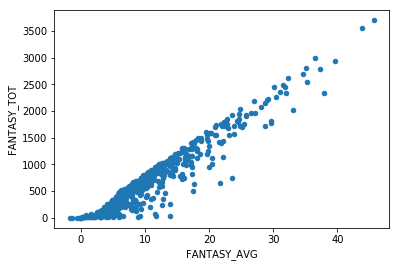

In [7]:
igralci.plot.scatter('FANTASY_AVG', 'FANTASY_TOT')

Z zgornjim grafom lahko na hitro (vendar natančno) preverimo, če je kakšno izrazito odstopanje od linearne odvisnosti skupne in povprečne vrednosti fantasy točkovanja, ki bi bila odvisna od npr. zelo majhnega števila odigranih tekem kakšnega igralca zaradi poškodbe. Nekaj takih primerov lahko opazimo, iz česar lahko sklepamo, da je nekaj igralcev (tudi boljših) moralo izpustiti večje število tekem, a je vzorec odigranih tekem še vedno dovolj velik, da jih lahko upoštevamo pri analizi.

V košarki so ponavadi zanimive (in hkrati nehvaležne) primerjave statistik igralcev, ki igrajo na različnih pozicijah. Poglejmo najprej zastopanost pozicij in povprečne indekse:

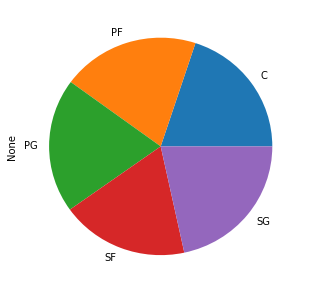

In [8]:
igralci.groupby('Position').size().plot.pie(figsize = (5,5))

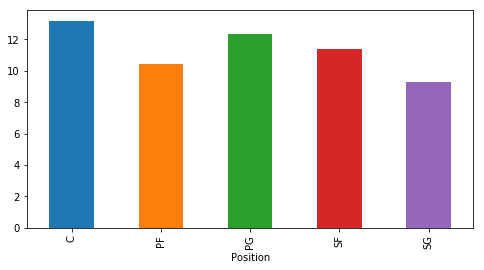

In [9]:
igralci.groupby('Position').mean().FANTASY_AVG.plot.bar(figsize=(8, 4))

Pred samo analizo dobljenega rezultata se spomnimo še same definicije pozicij:
    
C  - center

PF - krilni center

SF - krilo

SG - branilec

PG - organizator igre

Iz samega grafa lahko sicer opazimo nekaj razlik med pozicijami, ki pa niso pretirane. V bistvu bi lahko iz grafa sklepali, da tako točkovanje rahlo privilegira centre in organizatorje igre, saj imajo ti več možnosti, da dosežejo "dvojni dvojček"; prvi s skoki, drugi pa z asistencami. Vsekakor pa kar dobro uteži različne statistike. 

In [10]:
pregled = igralci[['Name', 'Position', 'Team', 'MIN', 'FANTASY_AVG']]
pregled = pregled[pregled['FANTASY_AVG'] > 30]
pregled

,Name,Position,Team,MIN,FANTASY_AVG
457,Russell Westbrook,PG,OKC,34.6,45.68
171,James Harden,PG,HOU,36.4,43.88
219,LeBron James,SF,CLE,37.8,39.67
118,Kevin Durant,SF,GSW,33.4,37.84
99,Anthony Davis,C,NOP,36.1,37.23
432,Karl-Anthony Towns,C,MIN,37.0,36.46
89,DeMarcus Cousins,C,TOT,34.2,35.26
15,Giannis Antetokounmpo,SF,MIL,35.6,35.11
451,John Wall,PG,WAS,36.4,34.59
350,Chris Paul,PG,LAC,31.5,33.11


In [11]:
pregled.groupby('Position').size()

Position
C     7
PG    5
SF    5
dtype: int64

Če pa še preverimo, kateri so najboljši igralci po fantasy točkovanju takoj opazimo, da je res največ centrov, sledijo pa jim organizatorji igre ter krila. 

Kar se individualnih statistik tiče, nima smisla da bi se preveč ustavljali pri posameznih statističnih kategorijah, na primer kdo je dosegel več točk ali asistenc, saj vse to zajame fantasy indeks. Veljalo pa bi še preveriti, kako je uspešnost igralcev povezana z igralnim časom ter začenjanjem tekem v prvi peterki.

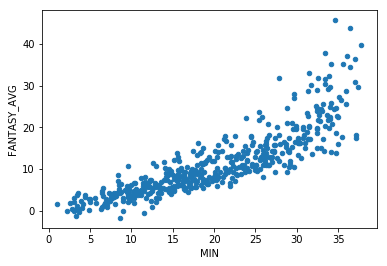

In [12]:
igralci.plot.scatter('MIN', 'FANTASY_AVG')

Za boljšo preglednost upoštevajmo igralni čas na 5 minut natančno (zaokrožimo navzgor). Postopek za relativiziranje velikosti "škatel" sem dobil na [povezavi](https://stackoverflow.com/questions/29286217/is-there-a-good-way-to-display-sample-size-on-grouped-boxplots-using-python-matp)

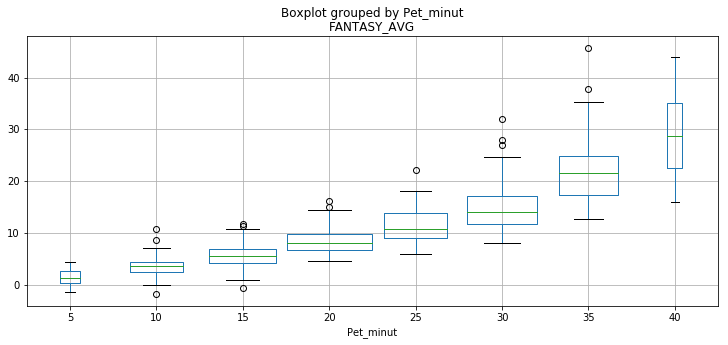

In [13]:
igralci['Pet_minut'] = (igralci.MIN // 5 + 1) * 5
igralci.Pet_minut = igralci.Pet_minut.astype(int)
igralci_po_casu = igralci.groupby('Pet_minut')

counts = [len(v) for k, v in igralci_po_casu]
total = float(sum(counts))
cases = len(counts)

widths = [5 * (c / total) for c in counts]

igralci.boxplot(column='FANTASY_AVG', by='Pet_minut', widths=widths, figsize=(12, 5))

Iz grafa je očitno, da je število odigranih minut močno povezano z učinkom igralca, kar je popolnoma logično. Kdor igra več časa ima več možnosti, da si izboljša statistiko in obratno, boljši igralci dobijo več priložnosti. Večja odstopanja so le pri kategoriji igralcev, ki preživi na parketu največ minut. To je spet povsem logično če izhajamo iz dejstva, da je pač število možnih minut omejeno, zato se okoli te "zgornje meje" naberejo boljši igralci, tisti najboljši pa imajo pač ob enakem odigranem času višji učinek. 

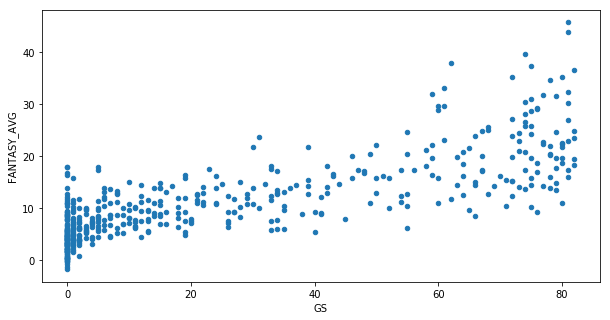

In [14]:
igralci.plot.scatter('GS','FANTASY_AVG', figsize=(10, 5))

Ta graf pa je precej bolj zanimiv, saj nas prisili k dodatni analizi. K standardnim začetnim peterkam ekip lahko pripišemo vse igralce, ki so približno 50-krat ali več začeli tekmo v igri, saj zaradi napornega ritma redkokaterim igralcem uspe odigrati vse tekme. Večkrat se pojavijo manjše poškodbe, utrujenost, precej trenerjev pa najboljšim igralcem na manj pomembnih tekmah nameni počitek. 

Pri igralcih iz začetnih peterk tako lahko vidimo podoben trend kot v prejšnjem grafu, torej da je precej dobrih igralcev, ki v tem primeru začenjajo tekme, tisti najboljši pa med temi precej izstopajo.

Bolj zanimivo je dogajanje na levi polovici grafa, torej pri igralcih, ki tekme začenjajo na klopi in le v primeru kakšne poškodbe (ali počitka standardne peterke) tekme začnejo na igrišču. Med temi lahko vidimo, da jih nekaj dosega kar visok indeks, tudi okoli 20 povprečno na tekmo, in presegajo marsikaterega igralca iz standardnih peterk. Poglejmo podrobneje, kaj vodi do tega:

In [15]:
rezerve = igralci[igralci.GS < 20]
rezerve[rezerve.FANTASY_AVG > 15]

,Name,Position,Age,Team,GP,GS,MIN,FG,FGA,FG_PCT,...,TO,PF,PTS,DD,TD,Wins,Losses,FANTASY_TOT,FANTASY_AVG,Pet_minut
242,Enes Kanter,C,24,OKC,72,0,21.3,5.6,10.2,0.55,...,1.7,2.1,14.3,18,0,47.0,35.0,1297.01,18.01,25
307,Greg Monroe,C,26,MIL,81,0,22.5,4.8,9.0,0.53,...,1.7,2.1,11.7,13,0,42.0,40.0,1458.05,18.00,25
370,Zach Randolph,PF,35,MEM,73,5,24.5,5.9,13.2,0.45,...,1.4,1.9,14.1,20,0,43.0,39.0,1303.76,17.86,25
227,James Johnson,PF,29,MIA,76,5,27.4,4.8,10.1,0.48,...,2.3,2.6,12.8,4,0,41.0,41.0,1318.90,17.35,30
210,Andre Iguodala,SF,33,GSW,76,0,26.3,2.9,5.5,0.53,...,0.8,1.3,7.6,0,0,67.0,15.0,1278.89,16.83,30
29,Will Barton,SG,26,DEN,60,19,28.4,4.9,11.1,0.44,...,1.6,1.8,13.7,2,0,40.0,42.0,984.61,16.41,30
230,Tyler Johnson,PG,24,MIA,73,0,29.8,4.9,11.3,0.43,...,1.2,2.4,13.7,0,0,41.0,41.0,1195.38,16.38,30
466,Lou Williams,SG,30,TOT,81,1,24.6,5.3,12.3,0.43,...,2.0,1.1,17.5,0,0,NaN,NaN,1278.78,15.79,25
328,Nerlens Noel,C,22,TOT,51,19,20.5,3.6,6.1,0.59,...,1.0,2.5,8.7,3,0,NaN,NaN,804.10,15.77,25
258,David Lee,PF,33,SAS,79,10,18.7,3.1,5.3,0.59,...,1.0,1.6,7.3,7,0,61.0,21.0,1189.58,15.06,20


Prvi pogled na "boljše" rezervne igralce nam pokaže, da so to vsekakor nadpovprečno dobri igralci (spomnimo se, da je bil povprečen indeks vseh igralcev med 10 in 11), ki tudi odigrajo kar precej minut na tekmo, vsi nad 20 in so skupno tudi odigrali veliko število tekem. To v bistvu pomeni, da niso bili prisiljeni na začenjanje tekem na klopi zaradi daljših odsotnosti ali nezmožnosti odigranja cele tekme na visokem nivoju. Razlog mora biti različen, lahko bi postavili hipotezo da je to taktična odločitev nekaterih trenerjev, da skušajo uravnotežit igro ekipe skozi celotno tekmo tudi na tak način, da ne pošljejo vseh najboljših takoj na igrišče. 

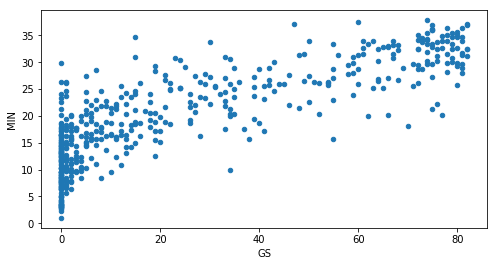

In [16]:
igralci.plot.scatter('GS','MIN', figsize=(8,4))

Res lahko opazimo, da marsikateri član standardne peterke igra v bistvu manj kot nekateri rezervni igralci.

Po opravljeni osnovni analizi uspešnosti igralcev nam ostane še zanimivejši del: še tako dobra statistika igralca je popolnoma nekoristna, če ekipa na koncu zabeleži poraz. Skušali bomo torej preveriti, če je fantasy točkovanje merodajno tudi pri uspešnosti posameznih ekip.

Primerjali bomo končni uspeh ekip s seštevkom fantasy točk vseh igralcev iz posamezne ekipe. Pri tem je treba še enkrat poudariti, da bomo pri rezultatih izgubili nekaj natančnosti, ker ne moremo upoštevati točk igralcev, ki so bili med letom zamenjani.

In [17]:
fantasy_povprecje = igralci.groupby('Team').sum().FANTASY_TOT
fantasy_lestvica = fantasy_povprecje.sort_values(ascending = False)
fantasy_lestvica = pd.Series.to_frame(fantasy_lestvica)
fantasy_lestvica = fantasy_lestvica[fantasy_lestvica.index != 'TOT']
fantasy_lestvica

,FANTASY_TOT
Team,
GSW,15561.32
SAS,13535.03
LAC,12692.20
HOU,12676.80
BOS,12618.12
WAS,12264.15
UTA,11760.24
IND,11655.64
MIL,11506.11


Generirali smo lestvico ekip po skupnem fantasy točkovanju, sedaj pa si oglejmo še končno lestvico rednega dela NBA sezone.

In [18]:
lestvica = ekipe.sort_values('Losses')
lestvica['Position'] = ekipe.index + 1
lestvica = lestvica[['Position', 'Team', 'Wins']]
lestvica['Index'] = lestvica['Position']
lestvica.set_index('Index', inplace=True)
lestvica[lestvica.columns[1:3]]

,Team,Wins
Index,,
1,GSW,67
2,SAS,61
3,HOU,55
4,BOS,53
5,CLE,51
6,TOR,51
7,UTA,51
8,LAC,51
9,WAS,49


Združimo obe lestvici v eno in jih uredimo po številu zmag ekip.

In [19]:
skupna_lestvica = pd.merge(lestvica, fantasy_lestvica, left_on = 'Team', right_on = 'Team')
skupna_lestvica.index = skupna_lestvica['Position']
skupna_lestvica[skupna_lestvica.columns[1:4]]

,Team,Wins,FANTASY_TOT
Position,,,
1,GSW,67,15561.32
2,SAS,61,13535.03
3,HOU,55,12676.80
4,BOS,53,12618.12
5,CLE,51,11490.21
6,TOR,51,10898.30
7,UTA,51,11760.24
8,LAC,51,12692.20
9,WAS,49,12264.15


Podatke analizirajmo s pomočjo grafov. Najprej si oglejmo povezavo med številom zmag in končno uvrstitvijo:

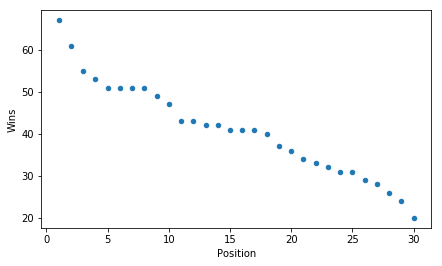

In [20]:
lestvica.plot.scatter('Position', 'Wins', figsize=(7,4))

Precej pričakovano je opazna zgostitev na sredini grafa, predvsem med 10. in 18. mestom oz. pri približno 50% izkupičku zmag (41/82), kar je vrednost ki ponavadi predstavlja mejo za uvrstitev v končnico tekmovanja.

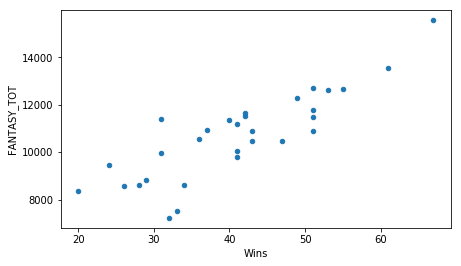

In [21]:
skupna_lestvica.plot.scatter('Wins', 'FANTASY_TOT', figsize=(7, 4))

Pri vrednotenju igralcev smo ugotovili, da je fantasy točkovanje kar merodajno glede na dejanske statistike, na prvi pogled pa tega ne moremo trditi za uspešnost ekip. Predvsem med slabšimi ekipami lahko opazimo izrazita odstopanja. Če se spomnimo, da smo morali točke nekaterih igralcev zanemariti, ker so med sezono zamenjali ekipo, lahko, vendar le delno upravičimo ta odstopanja. Od najboljših igralcev je le Demarcus Cousins zamenjal ekipo med sezono, in sicer iz Sacramento Kingsov je prešel v New Orleans Pelicanse. Poglejmo podrobneje:

In [23]:
igralci[igralci.Name == 'DeMarcus Cousins']

,Name,Position,Age,Team,GP,GS,MIN,FG,FGA,FG_PCT,...,TO,PF,PTS,DD,TD,Wins,Losses,FANTASY_TOT,FANTASY_AVG,Pet_minut
89,DeMarcus Cousins,C,26,TOT,72,72,34.2,9.0,19.9,0.45,...,3.7,3.9,27.0,46,2,NaN,NaN,2538.6,35.26,35


In [31]:
skupna_lestvica[(lestvica.Team == 'NOP') | (lestvica.Team == 'SAC')]

,Position,Team,Wins,FANTASY_TOT
Position,,,,
21,21,NOP,34,8600.57
23,23,SAC,32,7224.10


Ekipa Sacramenta ima res najnižji skupni indeks, vendar tudi če ji prištejemo polovico Cousinsovih točk, ima manj točk od vseh slabših ekip, ki so tudi zagotovo zamenjale kakšnega igralca med samo sezono. Naša nenatančnost torej ne vpliva bistveno na obliko zgornjega grafa.  

Na tej točki bi lahko spet postavili eno hipotezo, ki pa je s podatki, ki jih imamo na voljo, nedokazljiva. Marsikateri košarkarski strokovnjak trdi, da v košarki obramba zmaguje tekme. Obrambno igro pa je zelo težko oceniti z golo statistiko. Posameznemu igralcu lahko sicer štejemo ukradene žoge ali blokade, kar tudi fantasy točkovanje seveda upošteva, ekipne obrambe pa ne moremo izmeriti. Domnevamo lahko torej, da so ekipe, ki imajo nizek skupni indeks, a vseeno višje število zmag, bolj obrambno naravnane. Pri ekipah, ki se razlikujejo za res veliko število zmag se tega sicer ne opazi, saj je razlika v kakovosti prevelika, poleg tega pa že sam indeks upošteva bonuse za zmago na posamezni tekmi. Pri vrednostih, ki odstopajo, pa je ta hipoteza kar verjetna. 

Zaključimo lahko torej z ugotovitvijo, da je (glede na priljubljenost Fantasy prvenstev na spletu pričakovano) NBA Fantasy točkovanje kar realen pokazatelj kakovosti posameznikov, kar je tudi osnovni namen. Pogledali smo še, če bi lahko podobno trdili še za kakovost ekip, vendar smo ugotovili, da se ne ujema preveč z dejanskim uspehom.